# SSD7 Training Tutorial

This tutorial explains how to train an SSD7 on the Udacity road traffic datasets, and just generally how to use this SSD implementation.

Disclaimer about SSD7:
As you will see below, training SSD7 on the aforementioned datasets yields good results, but I'd like to emphasize that SSD7 is not a carefully optimized network architecture. The idea was just to build a low-complexity network that is fast (roughly 135 FPS or 3 times as fast as SSD300 on a GTX1070). Would slightly different anchor box scaling factors or a slightly different number of filters in individual convolution layers make SSD7 significantly better at similar complexity? I don't know, I haven't tried.

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from keras_ssd7 import build_model
from keras_ssd_loss import SSDLoss
from keras_layer_AnchorBoxes import AnchorBoxes
from keras_layer_L2Normalization import L2Normalization
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from ssd_batch_generator import BatchGenerator

%matplotlib inline

## 1. Set the model configuration parameters

The cell below sets a number of parameters that define the model configuration. The parameters set here are being used both by the `build_model()` function that builds the model as well as further down by the constructor for the `SSDBoxEncoder` object that is needed to run the training.

Hence, executing the code cell below is only necessary if you either want create a new model, or if you want to load a previously saved model and train it.

If you just want to load a previously saved model and do some inference with it, but no training, you don't need to execute the code cell below.

Here are some comments on a few of the parameters, read the documentation for details:

* Set the height, width, and number of color channels to whatever you want the model to accept as image input. This does not have to be the actual size of your input images! However, if your input images have a different size than you define as the model input here, you must use the `crop`, `resize` and/or `random_crop` features of the batch generator to convert your images to the model input size during training. If your dataset contains images of varying size, like the Pascal VOC datasets for example, use the `random_crop` feature of the batch generator to cope with that (see the documentation).
* The number of classes is the number of positive classes in your dataset, e.g. 20 for Pascal VOC or 80 for MS COCO. Class ID 0 must always be reserved for the background class, i.e. your positive classes must have positive and consecutive integers as their IDs.
* The reason why the list of scaling factors has 5 elements even though there are only 4 predictor layers in this model is that the last scaling factor is used for the second aspect-ratio-1 box of the last predictor layer. See the documentation for details.
* Alternatively to passing an explicit list of scaling factors, you could also just define a mimimum and a maximum scale, in which case the other scaling factors would be linearly interpolated. If you pass both min/max scaling factors and an explicit list, the explicit list will be used.
* `build_model()` and `SSDBoxEncoder` have two arguments for the anchor box aspect ratios: `aspect_ratios_global` and `aspect_ratios_per_layer`. You can use either of the two. If you use `aspect_ratios_global`, then you just pass a list containing all aspect ratios for which you would like to create anchor boxes. Every aspect ratio you want to include must be listed once and only once. If you use `aspect_ratios_per_layer`, then you pass a list containing lists of aspect ratios for each individual predictor layer. In the example below, the model has four predictor layers, so you would pass a list containing four lists.
* If `two_boxes_for_ar1 == True`, then two boxes of different size will be created for aspect ratio 1 for each predictor layer. See the documentation for details.
* If `limit_boxes == True`, then the generated anchor boxes will be limited so that they lie entirely within the image boundaries. This feature is called 'clip' in the original Caffe implementation. Even though it may seem counterintuitive, it is recommended **not** to clip the anchor boxes. According to Wei Liu, the model performs slightly better when the anchors are not clipped.
* The variances are scaling factors for the target coordinates. Leaving them at 1.0 for each of the four box coordinates means that they have no effect whatsoever. Decreasing them to below 1.0 **upscales** the gradient for the respective target box coordinate.
* The `coords` argument lets you choose what coordinate format the model should learn. If you choose the 'centroids' format, the targets will be converted to the (cx, cy, w, h) coordinate format used in the original implementation. If you choose the 'minmax' format, the targets will be converted to the coordinate format (xmin, xmax, ymin, ymax). The model, of course, will learn whatever the targets tell it to.
* `normalize_coords` converts all absolute ground truth and anchor box coordinates to relative coordinates, i.e. to coordinates that lie within [0,1] relative to the image height and width.

These paramters might be a bit much at first, but they allow you to configure many things easily.

The parameters set below are not only needed to build the model, but are also passed to the `SSDBoxEncoder` constructor in the subsequent cell, which is responsible for matching and encoding ground truth boxes and anchor boxes during training. In order to do that, it needs to know the anchor box specifications.

In [2]:
img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
subtract_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
divide_by_stddev = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 5 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
limit_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
coords = 'centroids' # Whether the box coordinates to be used should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True # Whether or not the model is supposed to use relative coordinates that are within [0,1]

## 2. Build or load the model

You will want to execute either of the two code cells in the subsequent two sub-sections, not both.

### 2.1 Create a new model

If you want to create a new model, this is the relevant section for you. If you want to load a previously saved model, skip ahead to section 2.2.

The code cell below does the following things:
1. It calls the function `build_model()` to build the model.
2. It then compiles the model for the training. In order to do so, we're defining an optimizer (Adam) and a loss function (SSDLoss) to be passed to the `compile()` method.

`SSDLoss` is a custom Keras loss function that implements the multi-task log loss for classification and smooth L1 loss for localization. `neg_pos_ratio` and `alpha` are set as in the paper and `n_neg_min` is a rather unimportant optional parameter to make sure that a certain number of negative boxes always enters the loss function even if there are very few or no positive boxes in a batch, which should never happen anyway.

In [11]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    limit_boxes=limit_boxes,
                    variances=variances,
                    coords=coords,
                    normalize_coords=normalize_coords,
                    subtract_mean=subtract_mean,
                    divide_by_stddev=divide_by_stddev,
                    swap_channels=False)

# 2: Optional: Load some weights

#model.load_weights('./ssd7_weights.h5')

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

### 2.2 Load a saved model

If you have previously created and saved a model and would now like to load it, simply execute the next code cell. The only thing you need to do is to set the path to the saved model HDF5 file that you would like to load.

The SSD model contains custom objects: Neither the loss function, nor the anchor box or L2-normalization layer types are contained in the Keras core library, so we need to provide them to the model loader.

In [ ]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'ssd7.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

## 3. Set up the data generators for the training

The code cells below set up batch generators for the training and validation datasets to train the model. You will have to set are the correct file paths to the images and labels of your dataset, and in case your labels do not come in a CSV file, you might have to switch from the CSV parser to the XML parser or you might have to write a new parser method in the `BatchGenerator` class that can handle whatever the format of your labels is. The [README](https://github.com/pierluigiferrari/ssd_keras/blob/master/README.md) of this project provides an overview of the design of the batch generator class, which should help you in case you need to write a new parser or adapt one of the existing parsers to your needs.

Set the batch size to whatever value you like (and that your GPU memory allows), it's not the most important hyperparameter - 32 works well, but so do most other batch sizes.

The `ssd_box_encoder` object, which, as explained above, knows how to match and encode the ground truth labels into the format that the model needs, is passed to the batch generator, which during training loads the next batch of images and labels, optionally performs data augmentation, and encodes the ground truth labels.

There are two parameters in the SSDBoxEncoder that you should note: `pos_iou_threshold` and `neg_iou_threshold`. The former determines the minimum Jaccard overlap between a ground truth box and an anchor box for a match and is set to 0.5, the value stated in the paper. The latter, `neg_iou_threshold`, is not in the paper, but it is useful to improve the learning process. It determines the maximum allowed Jaccard overlap between an anchor box and any ground truth box in order for that anchor box to be considered a negative box. This is useful because you want a clear margin between negative and positive boxes. An anchor box that almost contains an object should not be forced to learn to predict a negative box in such a case. 0.2 is a reasonable value that is used by various other object detection models.

Here is a brief overview of how the ground truth encoding and model output decoding are designed. The ground truth box matching and encoding happens as part of the mini batch generation. To be specific, the `generate()` method of `BatchGenerator` calls the `encode_y()` method of `SSDBoxEncoder` to encode the ground truth labels, and then yields the matched and encoded target tensor to be passed to the loss function. The decoding of the raw model output, confidence thresholding, and non-maximum suppression (NMS) is then performed by `decode_y()` and `decode_y2()`.

### Note:

The example setup below was used to train SSD7 on two road traffic datasets released by [Udacity](https://github.com/udacity/self-driving-car/tree/master/annotations) with around 20,000 images in total and 5 object classes (car, truck, pedestrian, bicyclist, traffic light), although the vast majority of the objects are cars. The original datasets have a constant image size of 1200x1920 RGB. I consolidated the two datasets, removed a few bad samples (although there are probably many more), and resized the images to 300x480 RGB, i.e. to one sixteenth of the original image size. In case you'd like to train a model on the same dataset, you can download the consolidated and resized dataset I used [here](https://drive.google.com/open?id=1uOqIUiJlDwoeL8vnNMacNbkDpDe1eRp-) (about 900 MB).

In [4]:
# 1: Instantiate to `BatchGenerator` objects: One for training, one for validation.

train_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])
val_dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])

In [5]:
# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = '../../datasets/udacity_driving_datasets/'

# Ground truth
train_labels_filename = '../../datasets/udacity_driving_datasets/labels_train.csv'
val_labels_filename   = '../../datasets/udacity_driving_datasets/labels_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets to compute the epoch lengths below.
n_train_samples = train_dataset.get_n_samples()
n_val_samples = val_dataset.get_n_samples()

print("n_train:", n_train_samples)
print("n_val:", n_val_samples)

n_train: 18000
n_val: 4241


### Note:

In the next cell we'll set some data augmentation options for the batch generator. These settings work, but they are not meant to be the ideal settings. Maybe different settings (for example more extreme augmentation) would yield better results. Experiment with this yourself.

In [8]:
# 3: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function. 

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('classes4').output_shape[1:3],
                   model.get_layer('classes5').output_shape[1:3],
                   model.get_layer('classes6').output_shape[1:3],
                   model.get_layer('classes7').output_shape[1:3]]

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                scales=scales,
                                aspect_ratios_global=aspect_ratios,
                                aspect_ratios_per_layer=None,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                steps=steps,
                                offsets=offsets,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

# 4: Set the batch size.

batch_size = 16 # Change the batch size if you like, or if you run into memory issues with your GPU.

# 5: Set the image processing / data augmentation options and create generator handles.

# Change the ad-hoc data augmentation settings as you like
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         convert_to_3_channels=True,
                                         equalize=False,
                                         brightness=(0.5, 2, 0.5), # Randomly change brightness between 0.5 and 2 with probability 0.5
                                         flip=0.5, # Randomly flip horizontally with probability 0.5
                                         translate=((5, 70), (3, 50), 0.5), # Randomly translate by 5-70 pixels horizontally and 3-50 pixels vertically with probability 0.5
                                         scale=(0.7, 1.4, 0.5), # Randomly scale between 0.7 and 1.4 with probability 0.5
                                         max_crop_and_resize=False,
                                         random_pad_and_resize=False,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=True,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     convert_to_3_channels=True,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     max_crop_and_resize=False,
                                     random_pad_and_resize=False,
                                     random_crop=False,
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.4)

## 4. Run the training

Now that everything is set up, we're ready to start training. Set the number of epochs and the model name, the weights name in `ModelCheckpoint` and the filepaths to wherever you'd like to save the model. There isn't much more to say here, just execute the cell. If you get "out of memory" errors during training, reduce the batch size.

Note that the number of epochs is arbitrarily set to 30 here. This does not imply that training for 30 epochs will be enough. You will usually need to train your model for tens of thousands of training steps. The number of training steps that one epoch consists of depends on the size of your training dataset and on the chosen batch size.

In [ ]:
# TODO: Set the number of epochs to train for.
epochs = 30

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('ssd7_weights_epoch-{epoch:02d}_loss-{loss:.4f}_valloss-{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           EarlyStopping(monitor='val_loss',
                                                         min_delta=0.01,
                                                         patience=7),
                                           ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.5,
                                                             patience=5,
                                                             epsilon=0.01,
                                                             cooldown=0)],
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))

# TODO: Set the filename (without the .h5 file extension!) under which to save the model and weights.
#       Do the same in the `ModelCheckpoint` callback above.
model_name = 'ssd7'
model.save('{}.h5'.format(model_name))
model.save_weights('{}_weights.h5'.format(model_name))

print()
print("Model saved under {}.h5".format(model_name))
print("Weights also saved separately under {}_weights.h5".format(model_name))
print()

Let's look at how the training and validation loss evolved to check whether our training is going in the right direction:

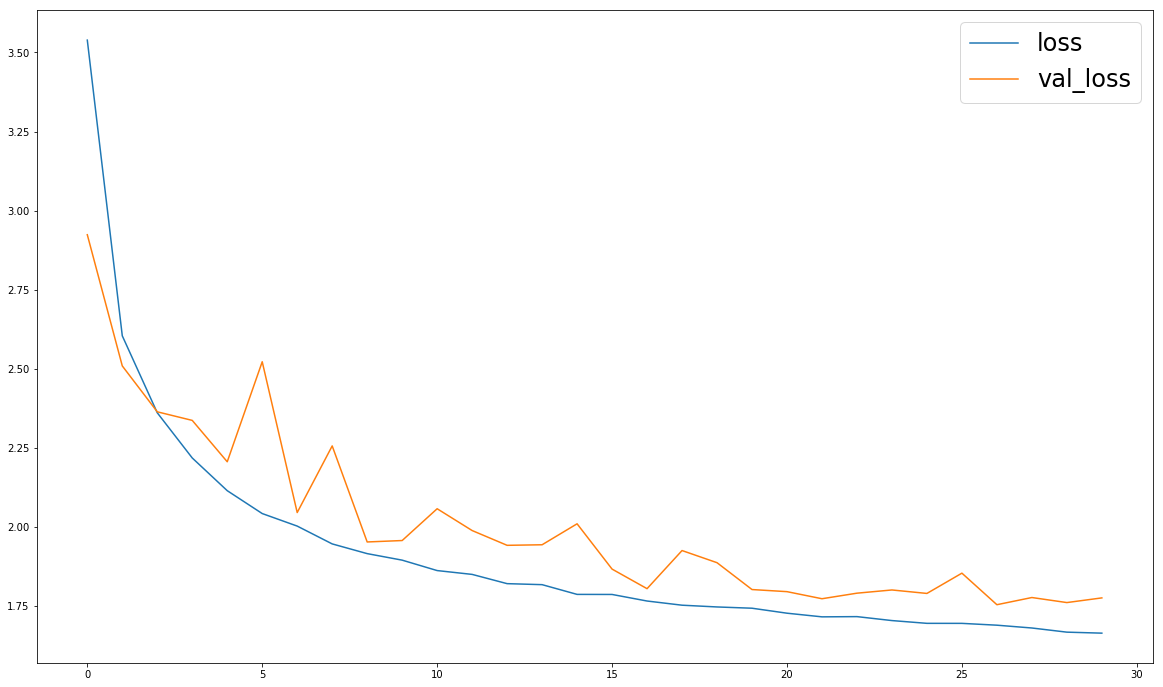

In [70]:
plt.figure(figsize=(20,12))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='upper right', prop={'size': 24});

Nice, the validation loss has been decreasing at a similar pace as the training loss, indicating that our model has been learning effectively over the last 30 epochs. We could try to train longer and see if the validation loss can be decreased any further. Once the validation loss stops decreasing for a couple of epochs in a row, that's when we will want to stop training. Our final weights will then be the weights of the epoch that had the lowest validation loss.

### 5. Make predictions

Now let's make some predictions on the validation dataset with the trained model. For convenience we'll use the validation generator which we've already set up above. Feel free to change the batch size.

You can set the `shuffle` option to `False` if you would like to check the model's progress on the same image(s) over the course of the training.

In [71]:
### Make predictions

# 1: Set the generator

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         train=False,
                                         returns={'processed_labels',
                                                  'filenames'},
                                         convert_to_3_channels=True,
                                         equalize=False,
                                         brightness=False,
                                         flip=False,
                                         translate=False,
                                         scale=False,
                                         max_crop_and_resize=False,
                                         random_pad_and_resize=False,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4)

In [99]:
# 2: Generate samples

X, y_true, filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", filenames[i])
print()
print("Ground truth boxes:\n")
print(y_true[i])

Image: ../../datasets/Udacity_Driving/driving_dataset_consolidated_small/1479505337936123141.jpg

Ground truth boxes:

[[  1   0 132  84 206]
 [  1  84 144 115 160]
 [  1 172 142 196 161]
 [  1 193 145 208 158]
 [  1 206 143 215 157]
 [  1 216 143 237 156]
 [  1 269 141 289 161]
 [  1 282 140 316 167]
 [  1 306 139 392 191]]


In [100]:
# 3: Make a prediction

y_pred = model.predict(X)

Now let's decode the raw prediction `y_pred`. The function `decode_y2()` converts the box coordinates from offsets back to absolute coordinates, keeps only the positive predictions (i.e. throws away all boxes for which the highest confidence is for class 0), applies a confidence threshold to all positive predictions, and applies non-maximum suppression to the remaining predictions, in this order. In case you would like to omit the NMS step, set `iou_threshold = None`.

You could also use `decode_y()`, which follows the prodecure outlined in the paper, to decode the raw predictions. The main point in which `decode_y()` and `decode_y2()` differ is that `decode_y2()` performs NMS globally and `decode_y()` performs NMS per class. It is important to understand what difference that makes. One point is that doing NMS per class for 20 classes will take roughly 20-times the time to do NMS just once over all classes, but this slow-down doesn't matter much when decoding a single batch. The more important point is to understand what difference it can make for the resulting final predictions. Performing NMS globally means that the strongest candidate box will eliminate all close boxes around it regardless of their predicted class. This can be good and bad. For example, if one box correctly predicts a sheep and another box incorrectly predicts a cow at similar coordinates, then global NMS would eliminate the incorrect cow box (because it is too close to the correct sheep box), while per-class NMS would not eliminate the incorrect cow box (because boxes are only compared within the same object class). On the other hand, if two objects of different classes are very close together and overlapping and are predicted correctly, then global NMS might eliminate one of the two correct predictions because they are too close together, while per-class NMS will keep both predictions. It's up to you which decoder you use.

In [104]:
# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_y2(y_pred,
                           confidence_thresh=0.5,
                           iou_threshold=0.4,
                           top_k='all',
                           input_coords='centroids',
                           normalize_coords=True,
                           img_height=img_height,
                           img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Decoded predictions (output format is [class_id, confidence, xmin, ymin, xmax, ymax]):\n")
print(y_pred_decoded[i])

Decoded predictions (output format is [class_id, confidence, xmin, ymin, xmax, ymax]):

[[  1.     0.97 173.58 144.77 194.06 158.88]
 [  1.     0.97  -7.34 126.3   85.44 195.1 ]
 [  1.     0.89 222.59 144.97 233.87 154.95]
 [  1.     0.8  193.94 146.16 209.79 156.31]
 [  1.     0.77 308.94 134.98 401.8  198.29]
 [  1.     0.75 279.55 142.01 316.55 173.64]
 [  1.     0.74  84.73 142.46 112.33 159.29]]


Finally, let's draw the predicted boxes onto the image in blue to visualize the result. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

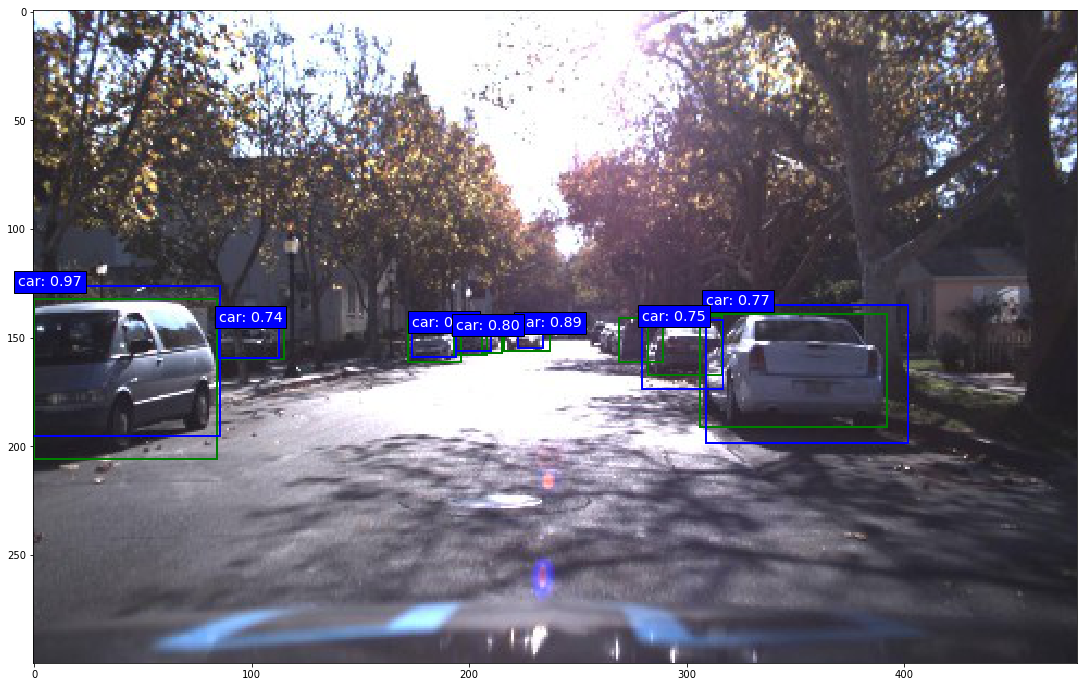

In [105]:
# 5: Draw the predicted boxes onto the image

plt.figure(figsize=(20,12))
plt.imshow(X[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, 6)).tolist() # Set the colors for the bounding boxes
classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in y_true[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    #current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Draw the predicted boxes in blue
for box in y_pred_decoded[i]:
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})